# AI-Powered Transaction Compliance Monitoring System with Document Ingestion

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mongodb-developer/GenAI-Showcase/blob/main/partners/ada/transaction_compliance_monitoring_system_with_document_ingestion.ipynb)

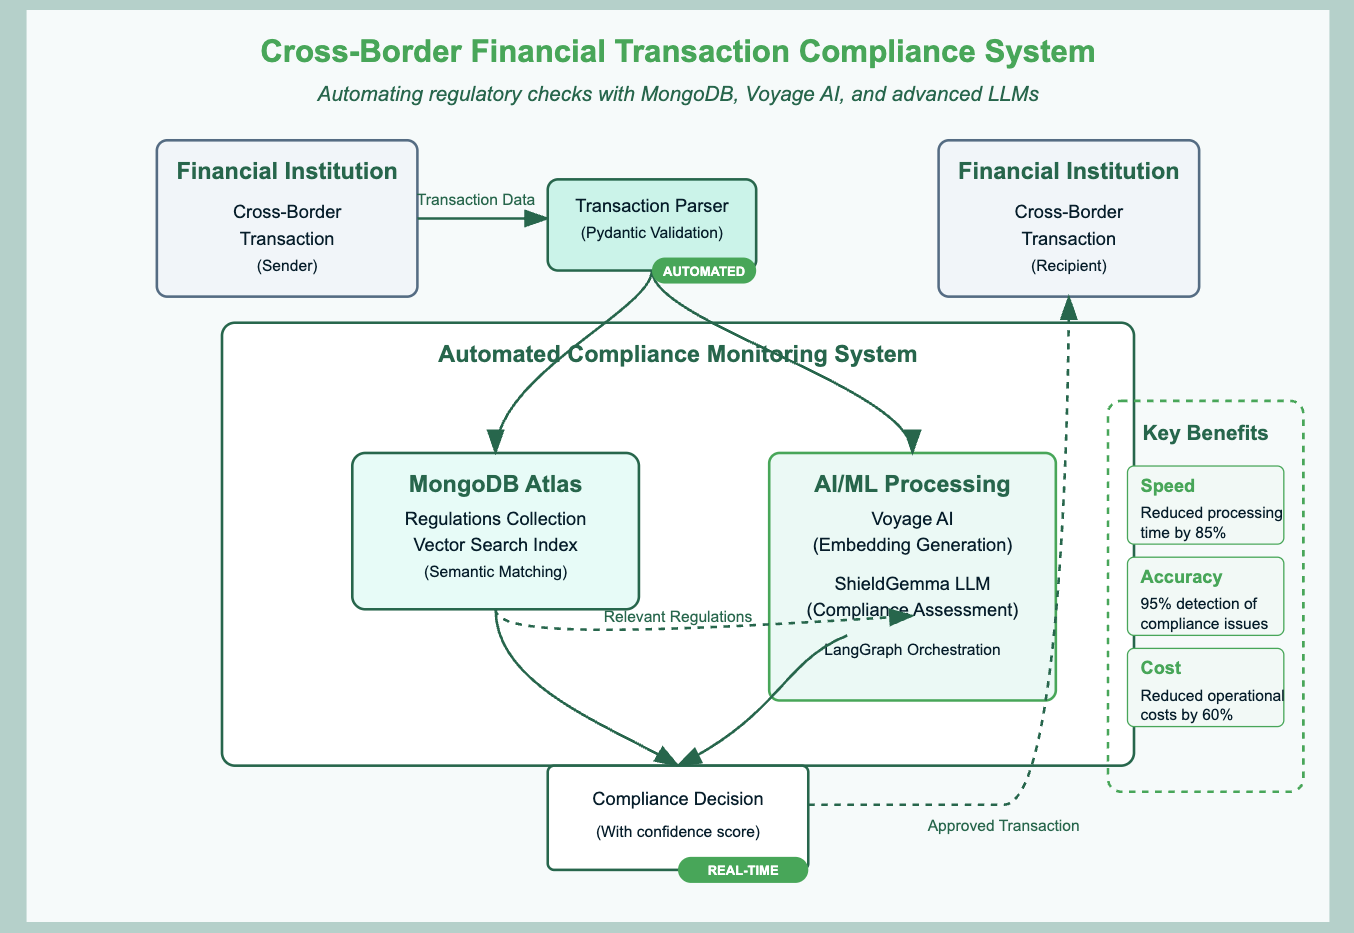

## Use Case Overview

In today's global financial ecosystem, institutions face the daunting challenge of ensuring every cross-border transaction complies with an increasingly complex web of international regulations. Manual compliance checks create bottlenecks, increase operational costs, and leave organizations vulnerable to costly violations and reputational damage.

In this use case, we are showcasing the foundation of a compliance monitoring system that leverages MongoDB's vector search capabilities, Voyage AI embedding models, and advanced LLMs to automate regulatory checks on financial transactions. This implementation demonstrates how to build a scalable transaction compliance checker with the following components:

### Core Components:
1. **Document Ingestion Pipeline**
   * PDF, DOC, DOCX, and structured text document processing
   * Automated metadata tagging based on document content
2. **Data Layer (Operational and Vector Database) (MongoDB Atlas)**
   * Storage for transaction data and regulatory policies with vector embeddings
   * Vector search index for semantic matching between transactions and applicable regulations
   * Checkpoint storage for LangGraph state management
   * Schema validation using Pydantic models
3. **NLP Processing Pipeline**
   * Text embedding generation via Voyage AI
   * Chunking strategies
4. **Compliance Assessment Engine**
   * ShieldGemma 9B model for transaction compliance evaluation against policies
   * Confidence scoring system for violation probability using softmax normalization
   * Threshold-based classification (Violation, Reporting Required, Compliant)
5. **Agent Orchestration Framework**
   * LangGraph-based workflow for agent coordination and state management
   * Tool-calling pattern for modular assessment capabilities
   * Asynchronous processing with MongoDB checkpointing

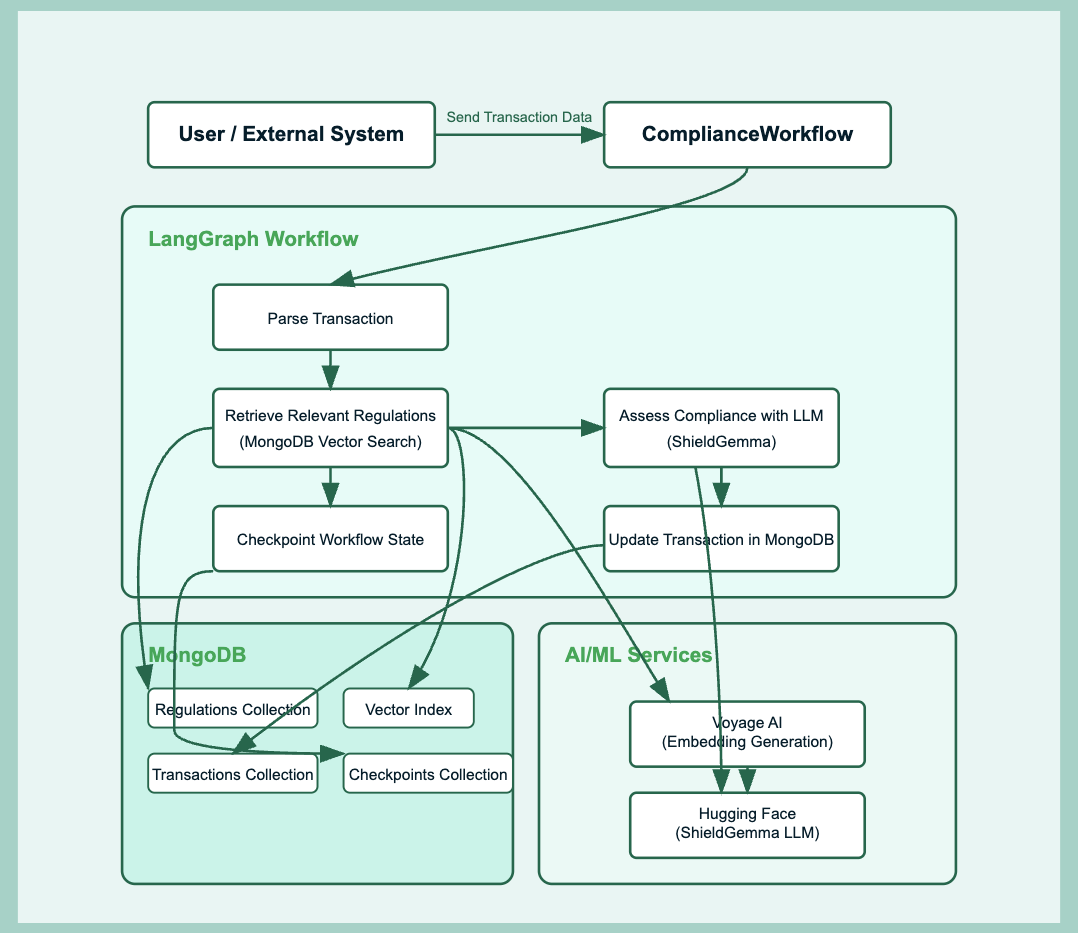

In [1]:
%pip install --quiet datasets pymongo langchain-mongodb langgraph-checkpoint-mongodb langchain-core langchain-huggingface langgraph pypdf python-docx unstructured pydantic voyageai transformers torch accelerator

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 31.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 42.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 85.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.9/148.9 kB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.3/302.3 kB 31.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.3/244.3 kB 27.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 93.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 127.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 98.9 MB/s eta 0:00:00
   

# Part 1: Environment and Database Setup

In [2]:
import getpass
import os


# Function to securely get and set environment variables
def set_env_securely(var_name, prompt):
    value = getpass.getpass(prompt)
    os.environ[var_name] = value

## Setup Environment Variables

First, we need to set up our environment variables for connecting to MongoDB Atlas and various AI services. You'll need to provide your own API keys and connection strings.


The cell block below initializes secure environment variables and defines key database configuration constants.
It prepares the system for connecting to external services including:
- MongoDB Atlas (document and vector storage)
- Voyage AI (embedding generation for semantic search)
- Hugging Face (LLM inference using the ShieldGemma-9B gated model)

Collections configured:
- Transactions, Regulations: Store transactional and regulatory data.
- Vector Index: For similarity search over embedded documents.
- Checkpoints: For managing resumable and incremental processing.

Note:
- Ensure you have valid API keys for MongoDB Atlas, Voyage AI, and Hugging Face.
- ShieldGemma-9B access requires accepting Hugging Face's gated model terms.

Here is a [link](https://docs.voyageai.com/docs/api-key-and-installation) that provides how to access Voyage AI API Key and Python Client.

Here is a [link](https://www.mongodb.com/resources/products/fundamentals/mongodb-connection-string#:~:text=The%20MongoDB%20connection%20string%20for,port%20number%20you%20are%20using.) on how to get your MongoDB Atlas connection string


In [3]:
import os
from datetime import datetime
from typing import Any, Dict, List, Optional, Union

# Set your MongoDB Atlas connection string
set_env_securely("MONGODB_URI", "Enter your MongoDB Atlas connection string: ")

# Set your Voyage AI API key for embeddings
set_env_securely("VOYAGE_API_KEY", "Enter your Voyage AI API key: ")

# Set your Hugging Face API key for the ShieldGemma 9B model
# shieldgemma-9b is a gated model, so you will need to accept the terms of service
# You can get a free API key from https://huggingface.co/settings/tokens
# - Make sure to enable "Read access to contents of all public gated repos you can access"
set_env_securely("HUGGINGFACE_API_KEY", "Enter your Hugging Face API key: ")

# Database configuration
DB_NAME = "compliance_monitoring_dev"
TRANSACTIONS_COLLECTION = "transactions"
REGULATIONS_COLLECTION = "regulations"
VECTOR_INDEX_NAME = "vector_index"
CHECKPOINTS_COLLECTION = "checkpoints"
CHECKPOINT_WRITES_COLLECTION = "checkpoint_writes"

Enter your MongoDB Atlas connection string: ··········
Enter your Voyage AI API key: ··········
Enter your Hugging Face API key: ··········


## MongoDB Connection and Collection Initialization (Ri)

Let's establish a connection to MongoDB Atlas and set up our collections.

The cell block establishes a connection to MongoDB Atlas using environment-secured credentials,
accesses required database collections, and ensures critical collections are created with
appropriate schema validation.

Main actions:
- Connect securely to MongoDB Atlas using the stable Server API v1.
- Verify connectivity with a cluster ping.
- Access the specified collections: transactions, regulations, checkpoints, checkpoint_writes.
- Create collections if missing:
  - Transactions collection is created with JSON schema validation to enforce data consistency.
  - Other collections are created without validation rules.

Note:
- 'validationLevel' is set to 'moderate' to validate inserts and updates while allowing legacy documents.
- A custom 'appname' is set for MongoDB application analytics and logging.


In [4]:
import time

from pymongo import MongoClient
from pymongo.operations import SearchIndexModel
from pymongo.server_api import ServerApi

# Create a new client and connect to the server
client = MongoClient(
    os.environ["MONGODB_URI"],
    server_api=ServerApi("1"),
    appname="devrel.showcase.partner.ada.compliance",
)

# Send a ping to confirm a successful connection
try:
    client.admin.command("ping")
    print("Successfully connected to MongoDB!")
except Exception as e:
    print(f"Failed to connect to MongoDB: {e}")

# Access the database and collections
db = client[DB_NAME]
transactions_collection = db[TRANSACTIONS_COLLECTION]
regulations_collection = db[REGULATIONS_COLLECTION]
checkpoints_collection = db[CHECKPOINTS_COLLECTION]
checkpoint_writes_collection = db[CHECKPOINT_WRITES_COLLECTION]


# Create collections with validation if they don't exist
def create_collections():
    # Get list of existing collections
    existing_collections = db.list_collection_names()

    # Create transactions collection with schema validation if it doesn't exist
    if TRANSACTIONS_COLLECTION not in existing_collections:
        db.create_collection(
            TRANSACTIONS_COLLECTION,
            validator={
                "$jsonSchema": {
                    "bsonType": "object",
                    "required": [
                        "transaction_id",
                        "amount",
                        "currency",
                        "sender",
                        "receiver",
                        "transaction_date",
                    ],
                    "properties": {
                        "transaction_id": {"bsonType": "string"},
                        "amount": {"bsonType": "double", "minimum": 0},
                        "currency": {"bsonType": "string"},
                        "sender": {"bsonType": "object"},
                        "receiver": {"bsonType": "object"},
                        "compliance_status": {"bsonType": "string"},
                    },
                }
            },
            validationLevel="moderate",
        )
        print(f"Created {TRANSACTIONS_COLLECTION} collection with schema validation")

    # Create regulations collection if it doesn't exist
    if REGULATIONS_COLLECTION not in existing_collections:
        db.create_collection(REGULATIONS_COLLECTION)
        print(f"Created {REGULATIONS_COLLECTION} collection")

    # Create checkpoints collection if it doesn't exist
    if CHECKPOINTS_COLLECTION not in existing_collections:
        db.create_collection(CHECKPOINTS_COLLECTION)
        print(f"Created {CHECKPOINTS_COLLECTION} collection")

    # Create checkpoints_writes collection if it doesn't exist
    if CHECKPOINT_WRITES_COLLECTION not in existing_collections:
        db.create_collection(CHECKPOINT_WRITES_COLLECTION)
        print(f"Created {CHECKPOINT_WRITES_COLLECTION} collection")

Successfully connected to MongoDB!


In [5]:
# Call function to create collections
create_collections()

**💡 Production Tip:**

**Always validate that environment variables like API keys are set before initializing any database or third-party clients to avoid silent failures in production.**

**Use moderate schema validation to catch bad data on insert/update without blocking reads of legacy documents. Tighten it over time as your application matures.**


## Vector Search Index Creation (Ri)

The `create_vector_search_index()`function ensures a vector search index exists on the 'regulations' collection
to enable semantic search capabilities over embedded document vectors.

Main actions:
- Check if a vector search index with the specified name already exists.
- If not present, create a new vector search index:
  - Embedding field: 'embedding'
  - Number of dimensions: 1024
  - Similarity metric: Cosine
- Poll the index build status until it becomes queryable.

Notes:
- The function uses a resilient design with error handling and retry polling.
- Adjust 'numDimensions' if your embeddings have a different vector size.
- Polling interval is 5 seconds; indexing completion may take up to a minute.


In [6]:
# Create vector search index if it doesn't exist
def create_vector_search_index():
    # Check if index already exists
    try:
        existing_indexes = regulations_collection.list_search_indexes()
        for index in existing_indexes:
            if index["name"] == VECTOR_INDEX_NAME:
                print(f"Vector search index '{VECTOR_INDEX_NAME}' already exists.")
                return
    except Exception as e:
        print(f"Could not list search indexes: {e}")
        return

    # Create vector search index
    search_index_model = SearchIndexModel(
        definition={
            "fields": [
                {
                    "type": "vector",
                    "path": "embedding",
                    "numDimensions": 1024,
                    "similarity": "cosine",
                }
            ]
        },
        name=VECTOR_INDEX_NAME,
        type="vectorSearch",
    )

    try:
        result = regulations_collection.create_search_index(model=search_index_model)
        print("New search index named '" + result + "' is building.")
    except Exception as e:
        print(f"Error creating vector search index: {e}")

    # Wait for initial sync to complete
    print("Polling to check if the index is ready. This may take up to a minute.")
    predicate = lambda index: index.get("queryable") is True

    while True:
        try:
            indices = list(regulations_collection.list_search_indexes(result))
            if indices and predicate(indices[0]):
                break
            time.sleep(5)
        except Exception as e:
            print(f"Error checking index readiness: {e}")
            time.sleep(5)

    print(f"{result} is ready for querying.")

In [7]:
# Call the function to create the vector search index
create_vector_search_index()

Vector search index 'vector_index' already exists.


**💡 Production Tip:**

**Always poll for vector index readiness after creation. Attempting searches on an unready index will cause avoidable runtime errors.**

# Part 2: Document Workflow Processing

## Document Processing and Schema Definition (Ry)

This module defines a structured schema for regulatory documents and provides utilities
to process and extract text from different file formats (PDF, DOCX, TXT).

Components:
- RegulationDocument (Pydantic Model):
  - Defines the structure for regulatory documents.
  - Supports optional fields like embeddings and text chunks.

- DocumentProcessor (Utility Class):
  - Extracts raw text from PDF, DOCX, and TXT files (file paths or byte streams).
  - Processes documents into RegulationDocument instances, with metadata inference.
  - Extracts additional metadata (jurisdiction, publication date, tags) from content using regex.

Notes:
- PDF parsing depends on the quality of the PDF (text-based PDFs are required).
- File format support is extensible (add handlers for more types if needed).
- Metadata extraction patterns can be customized for different document standards.


In [8]:
import io
import re

from docx import Document
from pydantic import BaseModel, Field
from pypdf import PdfReader


class RegulationDocument(BaseModel):
    """Schema for regulatory documents"""

    id: Optional[str] = None
    title: str
    content: str
    source: str
    document_type: str
    jurisdiction: str
    publication_date: str
    tags: List[str] = Field(default_factory=list)
    embedding: Optional[List[float]] = None
    chunks: Optional[List[Dict[str, Any]]] = None

    def to_dict(self):
        return self.model_dump(exclude_none=True)


class DocumentProcessor:
    """Processes different document formats and extracts text"""

    @staticmethod
    def extract_text_from_pdf(file_path_or_bytes):
        """Extract text from PDF files"""
        if isinstance(file_path_or_bytes, str):
            # It's a file path
            reader = PdfReader(file_path_or_bytes)
        else:
            # It's bytes
            reader = PdfReader(io.BytesIO(file_path_or_bytes))

        text = ""
        for page in reader.pages:
            text += page.extract_text() + "\n"
        return text

    @staticmethod
    def extract_text_from_docx(file_path_or_bytes):
        """Extract text from DOCX files"""
        if isinstance(file_path_or_bytes, str):
            # It's a file path
            doc = Document(file_path_or_bytes)
        else:
            # It's bytes
            doc = Document(io.BytesIO(file_path_or_bytes))

        text = ""
        for para in doc.paragraphs:
            text += para.text + "\n"
        return text

    @staticmethod
    def extract_text_from_txt(file_path_or_bytes):
        """Extract text from TXT files"""
        if isinstance(file_path_or_bytes, str):
            # It's a file path
            with open(file_path_or_bytes, encoding="utf-8") as f:
                return f.read()
        else:
            # It's bytes
            return file_path_or_bytes.decode("utf-8")

    @staticmethod
    def process_document(file_path, metadata=None):
        """Process a document and extract its text based on file extension"""
        if metadata is None:
            metadata = {}

        file_extension = file_path.split(".")[-1].lower()

        if file_extension == "pdf":
            text = DocumentProcessor.extract_text_from_pdf(file_path)
            doc_type = "pdf"
        elif file_extension == "docx":
            text = DocumentProcessor.extract_text_from_docx(file_path)
            doc_type = "docx"
        elif file_extension == "txt":
            text = DocumentProcessor.extract_text_from_txt(file_path)
            doc_type = "txt"
        else:
            raise ValueError(f"Unsupported file format: {file_extension}")

        # Extract title from filename if not provided
        if "title" not in metadata:
            title = os.path.basename(file_path).rsplit(".", 1)[0]
            metadata["title"] = title

        # Set document type if not provided
        if "document_type" not in metadata:
            metadata["document_type"] = doc_type

        # Create regulation document
        regulation = RegulationDocument(
            title=metadata.get("title", ""),
            content=text,
            source=metadata.get("source", file_path),
            document_type=metadata.get("document_type", doc_type),
            jurisdiction=metadata.get("jurisdiction", "Unknown"),
            publication_date=metadata.get(
                "publication_date", datetime.now().strftime("%Y-%m-%d")
            ),
            tags=metadata.get("tags", []),
        )

        return regulation

    @staticmethod
    def extract_metadata_from_content(content):
        """Extract metadata from document content using regex patterns"""
        metadata = {}

        # Extract jurisdiction
        jurisdiction_pattern = r"(?i)jurisdiction[:\s]+(\w+(?:\s+\w+)*)"
        jurisdiction_match = re.search(jurisdiction_pattern, content)
        if jurisdiction_match:
            metadata["jurisdiction"] = jurisdiction_match.group(1).strip()

        # Extract date
        date_pattern = r"(?i)(?:date|published)[:\s]+(\d{1,2}[/-]\d{1,2}[/-]\d{2,4}|\d{4}[/-]\d{1,2}[/-]\d{1,2})"
        date_match = re.search(date_pattern, content)
        if date_match:
            metadata["publication_date"] = date_match.group(1).strip()

        # Extract tags
        tags_pattern = r"(?i)(?:keywords|tags)[:\s]+([\w\s,]+)"
        tags_match = re.search(tags_pattern, content)
        if tags_match:
            tags = [tag.strip() for tag in tags_match.group(1).split(",")]
            metadata["tags"] = tags

        return metadata

**💡 Production Tip:**

**Normalize your extracted text early (e.g., clean line breaks, remove control characters) to avoid hidden issues during embedding or vector search stages.**

## Text Processing, Embedding Generation, and Storage

This cell block below defines a singleton TextProcessor class that handles:
- Splitting regulatory documents into manageable, overlapping text chunks.
- Generating vector embeddings for documents and their chunks using Voyage AI.
- Storing the fully processed documents into MongoDB for vector search and retrieval.

Main Features:
- Singleton pattern to efficiently reuse the Voyage AI client.
- Rate-limiting safeguard to respect Voyage API usage limits (3 requests per minute).
- Recursive character-based text splitter to preserve semantic structure in chunks.
- Separate embeddings for document-level and chunk-level search capabilities.

Notes:
- Adjust 'chunk_size' and 'chunk_overlap' based on model input constraints or document size.

In [9]:
import voyageai
from langchain_text_splitters import RecursiveCharacterTextSplitter


class TextProcessor:
    """Handles text chunking and embedding generation"""

    # Track the last time we called the Voyage API so we don't hit the rate limit
    last_voyage_call = 0
    _instance = None

    def __new__(cls, *args, **kwargs):
        if cls._instance is None:
            cls._instance = super().__new__(cls)
            cls._instance._initialized = False
        return cls._instance

    def __init__(self, chunk_size=1000, chunk_overlap=200):
        if not hasattr(self, "_initialized") or not self._initialized:
            self.chunk_size = chunk_size
            self.chunk_overlap = chunk_overlap
            self.text_splitter = RecursiveCharacterTextSplitter(
                chunk_size=chunk_size,
                chunk_overlap=chunk_overlap,
                length_function=len,
                separators=["\n\n", "\n", ".", "!", "?", ",", " ", ""],
            )
            self.voyage_client = voyageai.Client(api_key=os.environ["VOYAGE_API_KEY"])
            self.model_name = "voyage-3"
            self._initialized = True

    def chunk_text(self, text):
        """Split text into chunks"""
        return self.text_splitter.split_text(text)

    def generate_embeddings(self, texts):
        """Generate embeddings for a list of texts using Voyage AI"""
        if not texts:
            return []

        # Check time since last API call to respect rate limits (3 RPM)
        current_time = time.time()
        time_since_last_call = current_time - self.last_voyage_call

        # If less than 20 seconds have passed since last call, wait
        if time_since_last_call < 20:
            wait_time = 20 - time_since_last_call
            print(
                f"Rate limiting: waiting {wait_time:.2f} seconds before next API call"
            )
            time.sleep(wait_time)

        # Make the API call
        embeddings = self.voyage_client.embed(texts, model=self.model_name).embeddings

        # Update the last call timestamp
        self.last_voyage_call = time.time()

        return embeddings

    def process_document(self, regulation_doc):
        """Process a regulation document: chunk text and generate embeddings"""
        # Chunk the document content
        chunks = self.chunk_text(regulation_doc.content)

        # Generate embeddings for each chunk
        chunk_embeddings = self.generate_embeddings(chunks)

        # Create chunk objects with embeddings
        processed_chunks = []
        for i, (chunk, embedding) in enumerate(zip(chunks, chunk_embeddings)):
            processed_chunks.append(
                {
                    "chunk_id": f"{regulation_doc.id or 'doc'}_{i}",
                    "content": chunk,
                    "embedding": embedding,
                }
            )

        # Generate embedding for the entire document (using title + first chunk)
        doc_text = f"{regulation_doc.title}\n{chunks[0] if chunks else ''}"
        doc_embedding = self.generate_embeddings([doc_text])[0]

        # Update the regulation document
        regulation_doc.embedding = doc_embedding
        regulation_doc.chunks = processed_chunks

        return regulation_doc

    def store_regulation(self, regulation_doc):
        """Store a processed regulation document in MongoDB"""
        # Convert to dictionary for MongoDB storage
        regulation_dict = regulation_doc.to_dict()

        # Insert into MongoDB
        result = regulations_collection.insert_one(regulation_dict)
        print(f"Stored regulation document with ID: {result.inserted_id}")

        return result.inserted_id

**💡 Production Tip:**

**Choose your chunk size and overlap carefully:
Smaller chunks = better recall; larger chunks = better context preservation. Balance based on your downstream LLM input limits.**

## Sample Regulatory Document Ingestion Pipeline (Ry)

This cell block below demonstrates processing and storing sample regulatory documents
using the TextProcessor pipeline.

Workflow:
- Define sample regulations with metadata (title, jurisdiction, publication date, etc.).
- Instantiate the TextProcessor singleton to manage chunking and embedding generation.
- Process each regulation:
  - Chunk the document into semantic units.
  - Generate Voyage AI embeddings for both document-level and chunk-level.
  - Store the processed document into MongoDB for future vector search and retrieval.

Notes:
- Sample documents are representative; real-world ingestion would handle more variations.
- MongoDB collection schema must align with RegulationDocument's structure.
- Ensure that the MongoDB URI and Voyage API key are correctly configured before running.


In [10]:
# Sample regulatory texts
sample_regulations = [
    {
        "title": "Anti-Money Laundering Directive",
        "content": """ANTI-MONEY LAUNDERING DIRECTIVE
Jurisdiction: European Union
Date: 2021-06-15
Keywords: AML, KYC, financial crime, cross-border

Section 1: Scope and Definitions
1.1 This directive applies to all financial institutions operating within the European Union that process cross-border transactions.
1.2 'Cross-border transaction' refers to any financial transfer that originates in one country and terminates in another.
1.3 'High-risk jurisdiction' refers to countries identified by the Financial Action Task Force (FATF) as having strategic deficiencies in their AML/CFT regimes.

Section 2: Due Diligence Requirements
2.1 Enhanced due diligence must be performed for all transactions exceeding €10,000 that involve high-risk jurisdictions.
2.2 Financial institutions must verify the identity of both the sender and recipient for all cross-border transactions exceeding €3,000.
2.3 For transactions with sanctioned countries, prior approval must be obtained from the compliance department.

Section 3: Reporting Requirements
3.1 All suspicious transactions must be reported to the national Financial Intelligence Unit within 24 hours of detection.
3.2 Monthly reports must be submitted detailing all cross-border transactions exceeding €50,000.
3.3 Failure to report suspicious activities may result in fines of up to €5 million or 10% of annual turnover.
""",
        "source": "EU Financial Regulatory Authority",
        "document_type": "directive",
        "jurisdiction": "European Union",
        "publication_date": "2021-06-15",
        "tags": ["AML", "KYC", "financial crime", "cross-border"],
    },
    {
        "title": "Sanctions Compliance Framework",
        "content": """SANCTIONS COMPLIANCE FRAMEWORK
Jurisdiction: United States
Date: 2022-03-10
Keywords: sanctions, OFAC, restricted parties, compliance

Section 1: Overview
1.1 This framework outlines compliance requirements for financial institutions regarding transactions subject to sanctions administered by the Office of Foreign Assets Control (OFAC).
1.2 All US financial institutions and their foreign branches must comply with these requirements.

Section 2: Prohibited Transactions
2.1 No financial institution shall process transactions involving entities listed on the Specially Designated Nationals (SDN) list.
2.2 Transactions with entities in comprehensively sanctioned countries including Iran, North Korea, Syria, Cuba, and the Crimea region are prohibited without specific OFAC authorization.
2.3 Transactions that attempt to circumvent sanctions through third-party intermediaries are strictly prohibited and subject to severe penalties.

Section 3: Screening Requirements
3.1 All parties to a transaction must be screened against the most current OFAC sanctions lists prior to processing.
3.2 Screening must include beneficial owners with 25% or greater ownership interest.
3.3 Institutions must implement real-time screening for all international wire transfers regardless of amount.

Section 4: Penalties for Non-Compliance
4.1 Civil penalties may reach the greater of $1,000,000 per violation or twice the value of the transaction.
4.2 Criminal penalties for willful violations may include fines up to $20 million and imprisonment up to 30 years.
4.3 Financial institutions may be subject to regulatory actions including restrictions on activities or loss of licenses.
""",
        "source": "US Department of Treasury",
        "document_type": "framework",
        "jurisdiction": "United States",
        "publication_date": "2022-03-10",
        "tags": ["sanctions", "OFAC", "restricted parties", "compliance"],
    },
]

In [11]:
# Process and store sample regulations
text_processor = TextProcessor()

for reg_data in sample_regulations:
    # Create regulation document
    regulation = RegulationDocument(**reg_data)

    # Process document (chunk and generate embeddings)
    processed_regulation = text_processor.process_document(regulation)

    # Store in MongoDB
    regulation_id = text_processor.store_regulation(processed_regulation)
    print(f"Processed and stored regulation: {regulation.title}")

Rate limiting: waiting 20.00 seconds before next API call
Stored regulation document with ID: 6810dbcd5217a440bb14373f
Processed and stored regulation: Anti-Money Laundering Directive
Rate limiting: waiting 19.55 seconds before next API call
Rate limiting: waiting 20.00 seconds before next API call
Stored regulation document with ID: 6810dbf55217a440bb143740
Processed and stored regulation: Sanctions Compliance Framework


**💡 Production Tip:**

**Batch ingestion workflows should always wrap each document processing in a try/except block — one bad file shouldn't crash your entire ingestion pipeline..**

## Transaction Data Models and Compliance Status

This module defines structured models for representing financial transactions and transaction parties,
enforced with validation and serialization utilities.

Components:
- ComplianceStatus (Enum):
  - Defines standardized compliance outcomes for transactions.

- TransactionParty (Pydantic Model):
  - Represents details about a transaction party (sender or receiver).
  - Includes optional sanction status and risk scoring.

- Transaction (Pydantic Model):
  - Represents a full financial transaction, including metadata and compliance information.
  - Custom validator ensures transaction amounts are positive.
  - Utility methods:
    - 'to_dict()' for MongoDB or JSON storage.
    - 'to_prompt()' for generating LLM-friendly prompts or audit reports.

Notes:
- Amount validation helps prevent invalid transaction entries.
- Enum ensures consistent status values across the application.
- Expand 'compliance_details' as needed to fit more detailed compliance outputs.


In [13]:
from enum import Enum
from typing import Any, Dict, Optional

from pydantic import BaseModel, field_validator


class ComplianceStatus(str, Enum):
    """Enum for compliance status"""

    COMPLIANT = "Compliant"
    REPORTING_REQUIRED = "Reporting Required"
    VIOLATION = "Violation"
    PENDING = "Pending Assessment"


class TransactionParty(BaseModel):
    """Model for a party in a transaction (sender or receiver)"""

    name: str
    country: str
    account_number: str
    institution: str
    is_sanctioned: bool = False
    risk_score: Optional[float] = None


class Transaction(BaseModel):
    """Model for a financial transaction"""

    id: Optional[str] = None
    transaction_id: str
    amount: float
    currency: str
    sender: TransactionParty
    receiver: TransactionParty
    transaction_date: str
    transaction_type: str
    description: str
    compliance_status: ComplianceStatus = ComplianceStatus.PENDING
    compliance_details: Optional[Dict[str, Any]] = None

    @field_validator("amount")
    def amount_must_be_positive(cls, v):
        if v <= 0:
            raise ValueError("Amount must be positive")
        return v

    def to_dict(self):
        return self.model_dump(exclude_none=True)

    def to_prompt(self):
        """Convert transaction to a prompt-friendly format"""
        return f"""Transaction Details:
          - Transaction ID: {self.transaction_id}
          - Amount: {self.amount} {self.currency}
          - Date: {self.transaction_date}
          - Type: {self.transaction_type}
          - Description: {self.description}

          Sender Information:
          - Name: {self.sender.name}
          - Country: {self.sender.country}
          - Institution: {self.sender.institution}
          - Sanctioned: {self.sender.is_sanctioned}

          Receiver Information:
          - Name: {self.receiver.name}
          - Country: {self.receiver.country}
          - Institution: {self.receiver.institution}
          - Sanctioned: {self.receiver.is_sanctioned}
      """

**💡 Production Tip:**

**Use enums (like ComplianceStatus) whenever possible instead of free-text status fields — it prevents typos and enforces consistency across your platform.**


# Part 3: Workflow Ochestration with LangGraph and MongoDB

## Compliance Monitoring Engine and Workflow Orchestrator

This module provides a full AI-based system for assessing the compliance status of financial transactions
against regulatory documents using:

- Hugging Face ShieldGemma LLMs (2B or 9B models)
- MongoDB Atlas (vector search, checkpointing, transaction storage)
- Voyage AI for embedding generation
- LangGraph for stateful workflow orchestration

Components:
- ComplianceEngine:
  - Retrieves relevant regulations using vector search.
  - Performs compliance assessment using LLM with strict JSON output format.
  - Normalizes confidence scores using softmax.
  - Updates transaction records with compliance status and details.

- ComplianceWorkflow:
  - Defines a LangGraph-based workflow for processing transactions.
  - Includes checkpointing, error handling, and conditional retries.
  - Supports modular, resilient execution and session-based tracking.

Notes:
- Hugging Face account access and API keys are required for ShieldGemma models.
- MongoDB vector indexes must be set up beforehand.
- System is designed for extensibility (e.g., adding more workflow nodes for audit logging, risk scoring).



In [14]:
import numpy as np
import torch
from huggingface_hub import login
from langchain_core.output_parsers import JsonOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_huggingface import HuggingFacePipeline
from torch.nn.functional import softmax
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline


class ComplianceEngine:
    """Engine for assessing transaction compliance against regulations using LangChain with ShieldGemma"""

    # Can use "google/shieldgemma-2b" or "google/shieldgemma-9b"
    MODEL = "google/shieldgemma-2b"

    def __init__(self):
        # Initialize ShieldGemma model
        login(token=os.environ["HUGGINGFACE_API_KEY"])
        self.tokenizer = AutoTokenizer.from_pretrained(self.MODEL)
        model = AutoModelForCausalLM.from_pretrained(
            self.MODEL,
            torch_dtype=torch.bfloat16,
            device_map="auto",  # Remove if not using GPU
        )

        # Create a pipeline for text generation
        text_generation_pipeline = pipeline(
            "text-generation",
            model=model,
            tokenizer=self.tokenizer,
            max_new_tokens=1024,
            do_sample=False,
            pad_token_id=self.tokenizer.eos_token_id,
        )

        # Create LangChain HF Pipeline
        self.llm = HuggingFacePipeline(pipeline=text_generation_pipeline)

        self.text_processor = TextProcessor()

        # Define compliance assessment prompt template using LangChain
        self.assessment_prompt = ChatPromptTemplate.from_template(
            """You are a financial compliance expert with extensive knowledge of regulatory frameworks. Your task is to evaluate whether the following transaction complies with the specified regulations.

    Transaction Details:
    {transaction}

    Relevant Regulations:
    {regulations}

    Compliance Assessment Framework:
    - Compliant: Transaction fully adheres to all applicable regulations with no reporting requirements
    - Reporting Required: Transaction is legal but requires mandatory reporting to regulatory authorities
    - Violation: Transaction directly contravenes one or more regulatory requirements

    Step-by-step Analysis Process:
    1. Identify the transaction type and key participants
    2. Determine which specific regulations apply to this transaction
    3. Assess compliance with each applicable regulation
    4. Evaluate if reporting requirements exist
    5. Determine final compliance status

    Provide your assessment in the following JSON format:
    {{
        "status": "Compliant" | "Reporting Required" | "Violation",
        "confidence": <float between 0 and 1>,
        "reasoning": "<concise explanation with specific regulatory references>",
        "applicable_regulations": ["<specific regulation sections that apply>"],
        "recommended_actions": ["<actionable steps for compliance>"],
        "risk_factors": ["<key risk elements identified>"]
    }}

    Return ONLY the JSON object. No additional text, explanations, or formatting. YOU WILL BE PENALIZED IF YOU RETURN ANYTHING OTHER THAN THE JSON.
    """
        )

        # Output parser
        self.parser = JsonOutputParser()

        # Create the chain
        self.chain = self.assessment_prompt | self.llm | self.parser

    def retrieve_relevant_regulations(self, transaction):
        """Retrieve relevant regulations for a transaction using vector search"""
        # Generate embedding for the transaction
        transaction_text = transaction.to_prompt()
        transaction_embedding = self.text_processor.generate_embeddings(
            [transaction_text]
        )[0]

        # Perform vector search in MongoDB
        # Define the vector search stage
        vector_search_stage = {
            "$vectorSearch": {
                "index": VECTOR_INDEX_NAME,
                "queryVector": transaction_embedding,
                "path": "embedding",
                "numCandidates": 150,  # Number of candidate matches to consider
                "limit": 5,  # Return top 5 matches
            }
        }

        project_stage = {
            "$project": {
                "embedding": 0,  # Remove embedding from top-level documents
                "_id": 0,  # Remove _id
                "chunks": 0,  # Remove chunks
            }
        }

        # Define the aggregate pipeline with the vector search stage and additional stages
        pipeline = [vector_search_stage, project_stage]

        results = list(regulations_collection.aggregate(pipeline))

        # Format regulations for prompt
        regulations_text = ""
        for i, reg in enumerate(results, 1):
            regulations_text += f"Regulation {i}: {reg['title']} ({reg['jurisdiction']}, {reg['publication_date']})\n"
            regulations_text += f"{reg['content']}\n\n"

        return regulations_text

    def apply_softmax_normalization(self, assessment):
        """Apply softmax normalization to confidence scores"""
        # Calculate confidence scores for each status
        status_scores = {"Compliant": 0.0, "Reporting Required": 0.0, "Violation": 0.0}

        # Set the score for the predicted status
        status_scores[assessment["status"]] = assessment["confidence"]

        # Convert to array and apply softmax
        scores_array = np.array(list(status_scores.values()))
        normalized_scores = softmax(torch.tensor(scores_array), dim=0).numpy()

        # Update the confidence with normalized score
        assessment["confidence"] = float(
            normalized_scores[list(status_scores.keys()).index(assessment["status"])]
        )
        assessment["confidence_details"] = {
            status: float(score)
            for status, score in zip(status_scores.keys(), normalized_scores)
        }

        return assessment

    def assess_transaction(self, transaction):
        """Assess a transaction for compliance with softmax normalization"""
        try:
            # Retrieve relevant regulations
            regulations = self.retrieve_relevant_regulations(transaction)
            print("-" * 80)
            print(f"Retrieved {len(regulations)} relevant regulations.")
            print("Here are the first 100 characters of the first regulation:")
            print(regulations.split("\n")[0][:100])

            # Prepare inputs
            inputs = {
                "transaction": transaction.to_prompt(),
                "regulations": regulations,
            }

            # Run assessment
            assessment = self.chain.invoke(inputs)

            # Apply softmax normalization
            assessment = self.apply_softmax_normalization(assessment)

            # Update transaction with assessment results
            transaction.compliance_status = ComplianceStatus(assessment["status"])
            transaction.compliance_details = assessment

            # Store updated transaction in MongoDB
            if transaction.id:
                transactions_collection.update_one(
                    {"_id": transaction.id}, {"$set": transaction.to_dict()}
                )
                print(f"Updated transaction with ID: {transaction.id}")
            else:
                result = transactions_collection.insert_one(transaction.to_dict())
                transaction.id = str(result.inserted_id)
                print(f"Stored transaction with ID: {transaction.id}")

            return assessment

        except Exception as e:
            # Fallback if LangChain parsing fails
            print(f"Error during LangChain processing: {e}")
            # Create a default assessment
            assessment = {
                "status": "Reporting Required",
                "confidence": 0.5,
                "reasoning": f"Error during assessment: {e!s}. Please review the transaction manually.",
                "applicable_regulations": [],
                "recommended_actions": ["Review transaction manually"],
                "risk_factors": ["Assessment processing failure"],
            }
            return assessment

**💡 Production Tip:**

**Force LLMs to return strict JSON (like you do here) and validate outputs immediately. Never trust raw LLM output in critical systems without verification.**


## Agent Orchestration with LangGraph (Rich)

Now we'll implement the agent orchestration framework using LangGraph to coordinate the compliance assessment workflow.

In [15]:
from typing import Any, Dict, List, Optional, TypedDict

import langgraph.graph as lg
from langchain_core.messages import AIMessage, HumanMessage
from langgraph.checkpoint.mongodb import MongoDBSaver


# Define state for the graph
class ComplianceState(TypedDict):
    """State for the compliance assessment workflow"""

    transaction: Dict[str, Any]  # Transaction data
    regulations: Optional[List[Dict[str, Any]]]  # Retrieved regulations
    assessment: Optional[Dict[str, Any]]  # Compliance assessment results
    messages: List[Union[HumanMessage, AIMessage]]  # Conversation history
    errors: Optional[List[str]]  # Any errors encountered


class ComplianceWorkflow:
    """Orchestrates the compliance assessment workflow using LangGraph"""

    def __init__(self):
        self.compliance_engine = ComplianceEngine()
        self.text_processor = TextProcessor()

        # Create MongoDB checkpointer
        self.checkpoint_store = MongoDBSaver(client, DB_NAME, CHECKPOINTS_COLLECTION)

        # Build the graph
        self.workflow = self._build_graph()

    def _parse_transaction(self, state: ComplianceState) -> ComplianceState:
        """Parse transaction data and create Transaction object"""
        try:
            # Create Transaction object from state data
            transaction_data = state["transaction"]
            transaction = Transaction(**transaction_data)

            # Update state with parsed transaction
            state["transaction"] = transaction.to_dict()
            state["messages"].append(
                AIMessage(
                    content=f"Transaction {transaction.transaction_id} parsed successfully."
                )
            )

        except Exception as e:
            error_msg = f"Error parsing transaction: {e!s}"
            state["errors"] = state.get("errors", []) + [error_msg]
            state["messages"].append(AIMessage(content=error_msg))

        return state

    def _retrieve_regulations(self, state: ComplianceState) -> ComplianceState:
        """Retrieve relevant regulations for the transaction"""
        try:
            # Create Transaction object from state
            transaction = Transaction(**state["transaction"])

            # Retrieve relevant regulations
            regulations_text = self.compliance_engine.retrieve_relevant_regulations(
                transaction
            )

            # Update state with retrieved regulations
            state["regulations"] = regulations_text
            state["messages"].append(
                AIMessage(
                    content="Retrieved relevant regulations for compliance assessment."
                )
            )

        except Exception as e:
            error_msg = f"Error retrieving regulations: {e!s}"
            state["errors"] = state.get("errors", []) + [error_msg]
            state["messages"].append(AIMessage(content=error_msg))

        return state

    def _assess_compliance(self, state: ComplianceState) -> ComplianceState:
        """Assess transaction compliance against regulations"""
        try:
            # Create Transaction object from state
            transaction = Transaction(**state["transaction"])

            # Assess compliance
            assessment = self.compliance_engine.assess_transaction(transaction)

            # Update state with assessment results
            state["assessment"] = assessment
            state["transaction"] = (
                transaction.to_dict()
            )  # Update with compliance status

            # Add message with assessment summary
            summary = f"Compliance assessment complete. Status: {assessment['status']} (Confidence: {assessment['confidence']:.2f})\n"
            summary += f"Reasoning: {assessment['reasoning']}\n"
            if assessment.get("recommended_actions"):
                summary += f"Recommended actions: {', '.join(assessment['recommended_actions'])}\n"

            state["messages"].append(AIMessage(content=summary))

        except Exception as e:
            error_msg = f"Error assessing compliance: {e!s}"
            state["errors"] = state.get("errors", []) + [error_msg]
            state["messages"].append(AIMessage(content=error_msg))

        return state

    def _should_retry(self, state: ComplianceState) -> str:
        """Determine if workflow should retry or end based on errors"""
        if state.get("errors") and len(state["errors"]) < 3:
            return "retry"
        return "end"

    def _build_graph(self):
        """Build the LangGraph workflow"""
        # Define the graph
        builder = lg.StateGraph(ComplianceState)

        # Add nodes
        builder.add_node("parse_transaction", self._parse_transaction)
        builder.add_node("retrieve_regulations", self._retrieve_regulations)
        builder.add_node("assess_compliance", self._assess_compliance)

        # Define edges
        builder.add_edge("parse_transaction", "retrieve_regulations")
        builder.add_edge("retrieve_regulations", "assess_compliance")

        # Add conditional edge for error handling
        builder.add_conditional_edges(
            "assess_compliance",
            self._should_retry,
            {"retry": "parse_transaction", "end": lg.END},
        )

        # Set entry point
        builder.set_entry_point("parse_transaction")

        # Compile the graph with MongoDB checkpointing
        return builder.compile(checkpointer=self.checkpoint_store)

    def process_transaction(self, transaction_data: Dict[str, Any]) -> Dict[str, Any]:
        """Process a transaction through the compliance workflow"""
        # Initialize state
        initial_state = ComplianceState(
            transaction=transaction_data,
            regulations=None,
            assessment=None,
            messages=[
                HumanMessage(
                    content=f"Process transaction {transaction_data.get('transaction_id', 'unknown')}"
                )
            ],
            errors=None,
        )

        # Run the workflow
        # NOTE: The thread_id can be autogenerated to represent a session
        config = {"configurable": {"thread_id": "2"}}
        final_state = self.workflow.invoke(initial_state, config)

        return final_state


## Sample Transaction Compliance Processing (Ry)

The cell block below demonstrates processing sample financial transactions through the Compliance Workflow,
which uses the ComplianceEngine and LangGraph orchestration.

Workflow:
- Define two sample transactions involving cross-border wire transfers.
- Initialize the ComplianceWorkflow (which includes vector search, LLM-based compliance assessment, and MongoDB checkpointing).
- For each transaction:
  - Process the transaction through parsing, regulation retrieval, and compliance assessment.
  - Display system-generated messages and final compliance assessment results.
  - Output includes status, confidence score, reasoning, applicable regulations, and recommended actions.

Key Features:
- Demonstrates real-world scenarios including interactions with sanctioned entities.
- Supports softmax-normalized confidence scoring for compliance assessments.
- Full error handling and workflow resilience built into the processing pipeline.

Notes:
- Assumes regulations and vector indexes are preloaded in MongoDB.
- ShieldGemma LLM and Voyage embeddings are used in the backend.
- This serves as an end-to-end showcase for financial compliance monitoring automation.

Read the official LangGraph [docs](https://langchain-ai.github.io/langgraph/how-tos/persistence_mongodb/) on MongoDB for persistence



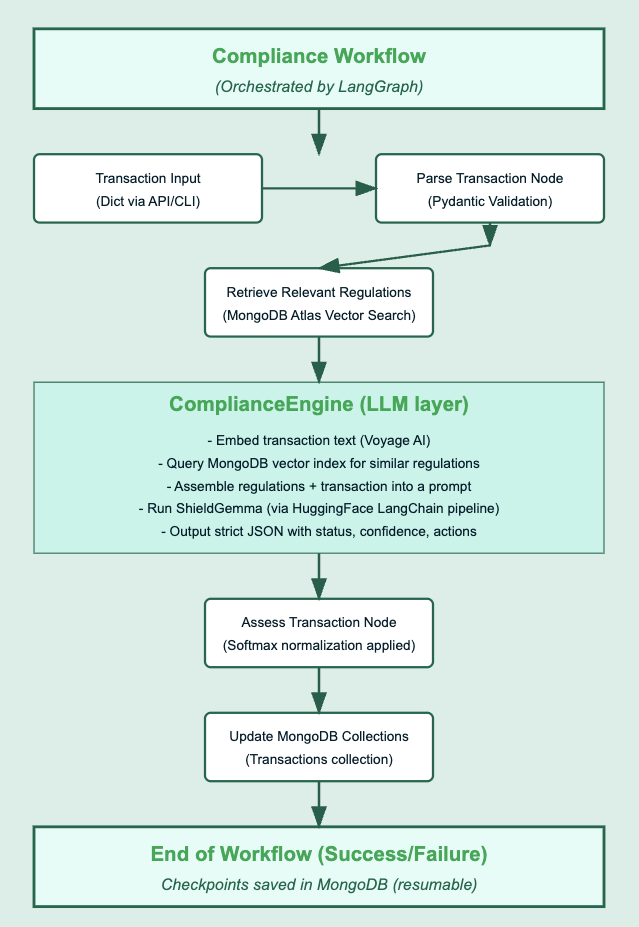

In [16]:
# Sample transactions for demonstration
sample_transactions = [
    {
        "transaction_id": "TX123456789",
        "amount": 150000.00,
        "currency": "EUR",
        "sender": {
            "name": "European Trading Ltd",
            "country": "Germany",
            "account_number": "DE89370400440532013000",
            "institution": "Deutsche Bank",
            "is_sanctioned": False,
        },
        "receiver": {
            "name": "Global Imports Inc",
            "country": "United States",
            "account_number": "US12345678901234567890",
            "institution": "Bank of America",
            "is_sanctioned": False,
        },
        "transaction_date": "2023-11-15",
        "transaction_type": "International Wire Transfer",
        "description": "Payment for machinery parts",
    },
    {
        "transaction_id": "TX987654321",
        "amount": 75000.00,
        "currency": "USD",
        "sender": {
            "name": "American Exports LLC",
            "country": "United States",
            "account_number": "US98765432109876543210",
            "institution": "JP Morgan Chase",
            "is_sanctioned": False,
        },
        "receiver": {
            "name": "Tehran Trading Co",
            "country": "Iran",
            "account_number": "IR123456789012345678901234",
            "institution": "Bank Melli Iran",
            "is_sanctioned": True,
        },
        "transaction_date": "2023-12-01",
        "transaction_type": "International Wire Transfer",
        "description": "Consulting services",
    },
]

In [17]:
# Initialize the compliance workflow
workflow = ComplianceWorkflow()

# Process each transaction
results = []
for tx_data in sample_transactions:
    print(f"\nProcessing transaction {tx_data['transaction_id']}...")
    result = workflow.process_transaction(tx_data)
    results.append(result)

    # Display messages from the workflow
    for message in result["messages"]:
        if isinstance(message, AIMessage):
            print(f"System: {message.content}")

    # Display final assessment
    if result.get("assessment"):
        assessment = result["assessment"]
        print(f"\nFinal Assessment for {tx_data['transaction_id']}:")
        print(f"Status: {assessment['status']}")
        print(f"Confidence: {assessment['confidence']:.2f}")
        print(f"Reasoning: {assessment['reasoning']}")
        if assessment.get("risk_factors"):
            print(f"Risk Factors: {', '.join(assessment['risk_factors'])}")
        if assessment.get("applicable_regulations"):
            print(
                f"Applicable Regulations: {', '.join(assessment['applicable_regulations'])}"
            )
        if assessment.get("recommended_actions"):
            print(
                f"Recommended Actions: {', '.join(assessment['recommended_actions'])}"
            )
        print("-" * 80)

tokenizer_config.json:   0%|          | 0.00/47.9k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/555 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/842 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/24.2k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/241M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/168 [00:00<?, ?B/s]

Device set to use cuda:0



Processing transaction TX123456789...
Rate limiting: waiting 19.83 seconds before next API call
--------------------------------------------------------------------------------
Retrieved 6358 relevant regulations.
Here are the first 100 characters of the first regulation:
Regulation 1: Anti-Money Laundering Directive (European Union, 2021-06-15)
Stored transaction with ID: 6810dc915217a440bb143741
System: Transaction TX123456789 parsed successfully.
System: Retrieved relevant regulations for compliance assessment.
System: Compliance assessment complete. Status: Reporting Required (Confidence: 0.55)
Reasoning: The transaction exceeds €10,000 and involves a cross-border transfer. Therefore, enhanced due diligence is required under Regulation 1 and 2.  Additionally, the transaction is a cross-border transfer exceeding €3,000, requiring identity verification under Regulation 2.
Recommended actions: Verify the identity of both the sender and receiver.


Final Assessment for TX123456789:
St

**💡 Production Tip:**

**Always log both system messages and errors during transaction processing — a clear audit trail can save you hours debugging compliance decisions later.**


## Conclusion

In this notebook, we've demonstrated a comprehensive AI-powered transaction compliance monitoring system that leverages MongoDB's vector search capabilities, Voyage AI embeddings, and advanced LLMs to automate regulatory checks on financial transactions.

The system includes:
1. A document ingestion pipeline for processing regulatory documents
2. A MongoDB Atlas data layer for storing transactions, regulations, and vector embeddings
3. An NLP processing pipeline for text chunking and embedding generation
4. A compliance assessment engine for evaluating transactions against regulations
5. A LangGraph-based agent orchestration framework for workflow management

This implementation provides a foundation that can be extended with additional features such as:
- Real-time transaction monitoring
- Integration with existing financial systems
- Advanced risk scoring algorithms
- Customizable compliance rules and thresholds
- Audit trail and reporting capabilities

By automating compliance checks, financial institutions can reduce operational costs, minimize human error, and ensure consistent application of regulatory requirements across all transactions.